In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from core import *
from train_functions import ave_auc
from utils import save_model
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import moment

In [2]:
PATH = Path('../data')
IMG_FOLDER_PATH = PATH/'ChestXRay-250'
TRADITIONAL_DATA_PATH = PATH/'traditional/14diseases/data'
TRADITIONAL_MODELS_PATH = PATH/'traditional/14diseases/models'

# Numerical features creation

In [3]:
def read_image_gray(path):
    im = cv2.imread(str(path)).astype(np.uint8)
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

def GLCM_features(im):
    GLCM = greycomatrix(im,[1,2,4,6], [0, np.pi/4, np.pi/2])
    properties = ['contrast','dissimilarity','homogeneity','ASM', 'energy', 'correlation']
    GLCM_features= [greycoprops(GLCM, prop) for prop in properties]
    return np.concatenate(GLCM_features).flatten()

def statistical_features(im):
    stat_feat1 = [np.mean(im),np.std(im)]
    stat_feat2 = [moment(im,moment=i,axis=None) for i in range(2,6)]
    return np.array(stat_feat1+stat_feat2)

def entropy(im):
        '''
        From https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        signal = im.flatten()
        symset=list(set(signal))
        lensig=float(signal.size)
        propab=[np.size(signal[signal==i])/lensig for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return np.array([ent])
    
def extract_features(im):
    features = [GLCM_features, statistical_features, entropy]
    return np.concatenate([feature(im) for feature in features])

def read_extract(im_path):
    im = read_image_gray(im_path)
    return extract_features(im)

def labels2array(x):
    return np.array(x.split(' ')).astype(int)

def read_img2features(df, base_path):
    '''Reads  all the images under base_path/ImageIndex and extracts their features. 
    
    :param df: df with columns ImageIndex and Labels.
    :param base_path: base path such that base_path/ImageIndex is the location of the image.
    :return: X - numerical features, Y - labels
    '''
    X = np.array([read_extract(base_path/row) for row in tqdm_notebook(df.ImageIndex)])
    Y = df.Label.values
    try: Y = np.array(list(map(labels2array, Y))) # 14 labels
    except: Y = Y.astype(int) # 1 label
    return X,Y

In [4]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

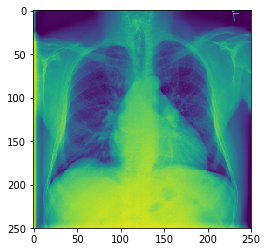

In [5]:
im = read_image_gray(str(IMG_FOLDER_PATH/train_df.ImageIndex[0]))
plt.imshow(im)

In [6]:
# Extract numerical features

# X_train, Y_train = read_img2features(train_df, base_path=IMG_FOLDER_PATH)
# X_valid, Y_valid = read_img2features(valid_df, base_path=IMG_FOLDER_PATH)
# X_test, Y_test = read_img2features(test_df, base_path=IMG_FOLDER_PATH)

# quantify NA's 

# print(f"# {np.isnan(X_train).sum(axis=1).sum()} - {np.isnan(X_train).sum(axis=1).sum()/X_train.shape[0]:.3f}%")
# print(f"# {np.isnan(X_valid).sum(axis=1).sum()} - {np.isnan(X_valid).sum(axis=1).sum()/X_valid.shape[0]:.3f}%")
# print(f"# {np.isnan(X_test).sum(axis=1).sum()} - {np.isnan(X_test).sum(axis=1).sum()/X_test.shape[0]:.3f}%")

# replace Na's 

def replacy_by_mean(array):
    means = np.nanmean(array,axis=0)
    mask = np.where(np.isnan(array))
    array[mask] = np.take(means, mask[1])
    return array

# X_train, X_valid, X_test = map(replacy_by_mean, [X_train, X_valid, X_test])

# Save

# np.save(TRADITIONAL_DATA_PATH/'X_train', X_train)
# np.save(TRADITIONAL_DATA_PATH/'Y_train', Y_train)

# np.save(TRADITIONAL_DATA_PATH/'X_valid', X_valid)
# np.save(TRADITIONAL_DATA_PATH/'Y_valid', Y_valid)

# np.save(TRADITIONAL_DATA_PATH/'X_test', X_test)
# np.save(TRADITIONAL_DATA_PATH/'Y_test', Y_test)

In [7]:
# Load
X_train = np.load(TRADITIONAL_DATA_PATH/'X_train.npy')
Y_train = np.load(TRADITIONAL_DATA_PATH/'Y_train.npy')

X_valid = np.load(TRADITIONAL_DATA_PATH/'X_valid.npy')
Y_valid = np.load(TRADITIONAL_DATA_PATH/'Y_valid.npy')

X_test = np.load(TRADITIONAL_DATA_PATH/'X_test.npy')
Y_test = np.load(TRADITIONAL_DATA_PATH/'Y_test.npy')

# Training

In [8]:
# from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, roc_auc_score

/data/miguel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Sklearn does not currently support multi-label logistic regression with all (l1, l2 and l1 & l2) regularizations that we want to use. Therefore, we implemented those with a swallow neural network and modified loss functions in PyTroch.

In [20]:
# DATASET
class feature_ds(Dataset):

    def __init__(self, X,Y):
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

    def __getitem__(self, index):
        x = self.X[index,:]
        y = self.Y[index,:]
        return x, y

    def __len__(self): return self.X.shape[0]

# ARCHITECTURE
class multilabel_log_reg(nn.Module):
    
    def __init__(self, in_dim=79, out_dim=14): 
        super(multilabel_log_reg, self).__init__()
        self.linear = nn.Linear(in_features=in_dim,out_features=out_dim)
        
    def forward(self, x):
        out = self.linear(x)
        return out

# REGULARIZATIONS
# Note: We are using L1 and L2 regularization, NOT weight decay!
def ridge_regularization(model, **kwarg):
    return sum([kwarg['alpha']*torch.norm(p, 2) for p in model.parameters()])

def lasso_regularization(model, **kwarg):
    return sum([kwarg['alpha']*torch.norm(p,1) for p in model.parameters()])
            
def elastic_net_regularization(model, **kwarg):
    wgt_l1 = kwarg['l1_ratio']*kwarg['alpha']
    wgt_l2 = (1-kwarg['l1_ratio'])*kwarg['alpha']
    return sum([wgt_l1*torch.norm(p,1) + wgt_l2*torch.norm(p,2) for p in model.parameters()])

# VALIDATION LOOP
def validation(model, valid_dl):
    '''
    
    :return: val loss (with regularization), average auc
    '''
    model.eval()
    total = 0
    sum_loss = 0
    
    ys = []
    logits = []
    
    for x, y in valid_dl:
        batch = y.shape[0]
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(input=out,target=y)
        
        
        y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch
        
        logits.append(out.cpu().detach().numpy())
        ys.append(y.long().cpu().numpy())

    ys = np.vstack(ys)
    logits = np.vstack(logits)
    auc, _ = ave_auc(logits, ys)

    return sum_loss / total, auc

# TRAINING_LOOP
reg_dic = {'ridge': ridge_regularization,
           'lasso': lasso_regularization,
           'elastic-net': elastic_net_regularization}

def train(model, dl_train, dl_val, path, reg_type, lr_high=1e-2, lr_low=1e-7, epochs=4, epsilon=.01, **kwarg):
    
    lr = lr_high
    prev_loss = np.inf
    min_loss = np.inf
    reg_f = reg_dic[reg_type]
    
    for epoch in tqdm_notebook(range(epochs), leave=False):
        model.train()
        total,sum_loss = 0,0
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        for x,y in dl_train:

            x,y = x.cuda(),y.cuda()
#             x,y = x.cpu(),y.cpu()
            
#             model = model.cpu()
            
            
            pred = model(x)
            loss = F.binary_cross_entropy_with_logits(input=pred,target=y) + reg_f(model, **kwarg)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            batch = y.shape[0]
            sum_loss += batch * (loss.item())
            total += batch

        val_loss, auc = validation(model, dl_val)
        
        if epoch%10==0: print(f"lr {lr:.7f} train loss {sum_loss/total:.3f} - val loss {val_loss} avg AUC - {auc}")
        
        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            save_model(model, path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < lr_low:
            break
    return min_loss

# Hyper-parameter tunning

We do that with the whole dataset.

In [10]:
# define data loaders

train_ds = feature_ds(X_train, Y_train)
valid_ds = feature_ds(X_valid, Y_valid)
test_ds = feature_ds(X_test, Y_test)

dl_train = DataLoader(train_ds, batch_size=Y_train.shape[0], shuffle=True)
dl_valid = DataLoader(valid_ds, batch_size=Y_valid.shape[0], shuffle=True)
dl_test = DataLoader(test_ds, batch_size=Y_test.shape[0], shuffle=True)

In [23]:
# Ridge
grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]

min_val_loss, min_path, min_alpha = np.inf, None, None

for alpha in grid:
    kwarg = {'alpha': alpha}
    lin_model = multilabel_log_reg().cuda()
    print(f"alpha: {alpha}...")
    
    save_path = TRADITIONAL_MODELS_PATH/'ridge_{alpha}.pth'
    
    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                                     reg_type='ridge', path=save_path, lr_low=1e-6, lr_high=1e-2,
                                     epochs=50, **kwarg)
    
    # Keep only the model with the smallest val_loss
    if min_val_loss > val_loss:
        min_alpha = alpha
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)
        
min_alpha

alpha: 0.1...


A Jupyter Widget

lr 0.0100000 train loss 77626216.000 - val loss 64590484.0 avg AUC - 0.5008559569604225
lr 0.0010000 train loss 3299758.500 - val loss 2530889.25 avg AUC - 0.512501189782518
lr 0.0001000 train loss 798952.562 - val loss 687073.0625 avg AUC - 0.5229746729379235
lr 0.0001000 train loss 734029.625 - val loss 636152.875 avg AUC - 0.5246306947012015
lr 0.0001000 train loss 718159.125 - val loss 622989.5 avg AUC - 0.5244877234676811
alpha: 0.2...


A Jupyter Widget

lr 0.0100000 train loss 51387556.000 - val loss 39959512.0 avg AUC - 0.5037114244041102
lr 0.0100000 train loss 2552924.500 - val loss 2392801.5 avg AUC - 0.5045492264016709
lr 0.0010000 train loss 852128.875 - val loss 656217.4375 avg AUC - 0.5227503983475712
lr 0.0001000 train loss 585732.000 - val loss 535389.6875 avg AUC - 0.520061990696446
lr 0.0001000 train loss 568405.625 - val loss 522710.15625 avg AUC - 0.5206490518500001
alpha: 0.3...


A Jupyter Widget

lr 0.0100000 train loss 61696456.000 - val loss 48408768.0 avg AUC - 0.5071889545240842
lr 0.0100000 train loss 3354023.250 - val loss 2281147.0 avg AUC - 0.5205609819321888
lr 0.0010000 train loss 597912.375 - val loss 521265.09375 avg AUC - 0.5183681720678593
lr 0.0001000 train loss 526228.375 - val loss 455965.0 avg AUC - 0.5193341046044385
lr 0.0001000 train loss 513175.844 - val loss 445094.59375 avg AUC - 0.5194633460844575
alpha: 0.4...


A Jupyter Widget

lr 0.0100000 train loss 63315656.000 - val loss 49547152.0 avg AUC - 0.5021701725229878
lr 0.0010000 train loss 3243304.500 - val loss 2362202.0 avg AUC - 0.49866712380350003
lr 0.0001000 train loss 482216.625 - val loss 405041.625 avg AUC - 0.5241043002729313
lr 0.0001000 train loss 394414.281 - val loss 340762.375 avg AUC - 0.5268842094411241
lr 0.0001000 train loss 382100.344 - val loss 329566.125 avg AUC - 0.5268555387133834
alpha: 0.5...


A Jupyter Widget

lr 0.0100000 train loss 44975136.000 - val loss 34847400.0 avg AUC - 0.5009095124034981
lr 0.0010000 train loss 3009391.000 - val loss 2423150.75 avg AUC - 0.5215864560614308
lr 0.0010000 train loss 543353.250 - val loss 502928.40625 avg AUC - 0.5251416831248925
lr 0.0001000 train loss 493729.281 - val loss 435075.25 avg AUC - 0.5251959298086993
lr 0.0001000 train loss 481687.094 - val loss 424792.03125 avg AUC - 0.5256060776466633
alpha: 0.6...


A Jupyter Widget

lr 0.0100000 train loss 44857556.000 - val loss 31546962.0 avg AUC - 0.49536940989255157
lr 0.0010000 train loss 2090443.000 - val loss 1549220.5 avg AUC - 0.5141363405837879
lr 0.0001000 train loss 637430.438 - val loss 558306.5625 avg AUC - 0.5238864194632455
lr 0.0001000 train loss 570226.625 - val loss 508875.6875 avg AUC - 0.5245378989183341
lr 0.0001000 train loss 547481.375 - val loss 487885.25 avg AUC - 0.5245707839246595
alpha: 0.7...


A Jupyter Widget

lr 0.0100000 train loss 45671576.000 - val loss 36422296.0 avg AUC - 0.5118129822338402
lr 0.0100000 train loss 3802263.750 - val loss 2971944.25 avg AUC - 0.5053625011140073
lr 0.0010000 train loss 684553.750 - val loss 515980.21875 avg AUC - 0.5183836893049739
lr 0.0001000 train loss 495122.562 - val loss 447392.375 avg AUC - 0.5167349720009762
lr 0.0001000 train loss 481932.188 - val loss 435569.4375 avg AUC - 0.5165054963311928
alpha: 0.8...


A Jupyter Widget

lr 0.0100000 train loss 61222904.000 - val loss 50547276.0 avg AUC - 0.49185097657128946
lr 0.0100000 train loss 3435118.000 - val loss 2776005.0 avg AUC - 0.5315661251480687
lr 0.0010000 train loss 605876.062 - val loss 533335.0625 avg AUC - 0.5247937342565914
lr 0.0001000 train loss 522242.125 - val loss 480776.75 avg AUC - 0.5246036269565978
lr 0.0001000 train loss 508836.875 - val loss 469365.78125 avg AUC - 0.5245800687186302
alpha: 0.9...


A Jupyter Widget

lr 0.0100000 train loss 57032936.000 - val loss 45457324.0 avg AUC - 0.5034491879620648
lr 0.0010000 train loss 4754258.000 - val loss 3803682.5 avg AUC - 0.5109857955978266
lr 0.0001000 train loss 627407.312 - val loss 532042.5 avg AUC - 0.518677678341868
lr 0.0001000 train loss 561341.062 - val loss 480048.75 avg AUC - 0.5222456212866242
lr 0.0001000 train loss 544531.625 - val loss 466567.21875 avg AUC - 0.5228722252792076
alpha: 1...


A Jupyter Widget

lr 0.0100000 train loss 59534544.000 - val loss 46142684.0 avg AUC - 0.4887774298246386
lr 0.0100000 train loss 2908703.000 - val loss 2963558.75 avg AUC - 0.5057752432538277
lr 0.0010000 train loss 458558.781 - val loss 439384.125 avg AUC - 0.5158728075398632
lr 0.0001000 train loss 410975.875 - val loss 369090.875 avg AUC - 0.5214135959062167
lr 0.0001000 train loss 397322.344 - val loss 357907.53125 avg AUC - 0.5220050573624733
alpha: 2...


A Jupyter Widget

lr 0.0100000 train loss 52104384.000 - val loss 41594768.0 avg AUC - 0.5146796646855356
lr 0.0100000 train loss 1915917.375 - val loss 2689018.0 avg AUC - 0.5291639345194545
lr 0.0001000 train loss 532323.688 - val loss 460559.9375 avg AUC - 0.5295563792093914
lr 0.0001000 train loss 479200.250 - val loss 419982.59375 avg AUC - 0.5257605324377709
lr 0.0001000 train loss 464287.594 - val loss 407312.90625 avg AUC - 0.5257636366164414
alpha: 4...


A Jupyter Widget

lr 0.0100000 train loss 53311152.000 - val loss 42668056.0 avg AUC - 0.49450087921997454
lr 0.0010000 train loss 2114550.500 - val loss 1666209.375 avg AUC - 0.518570736666695
lr 0.0010000 train loss 530349.062 - val loss 519883.96875 avg AUC - 0.5164355890701023
lr 0.0001000 train loss 462104.594 - val loss 446139.5625 avg AUC - 0.5193141314818341
lr 0.0001000 train loss 443548.312 - val loss 427515.71875 avg AUC - 0.5193274645495688
alpha: 8...


A Jupyter Widget

lr 0.0100000 train loss 33267122.000 - val loss 24376502.0 avg AUC - 0.49179529803814187
lr 0.0010000 train loss 4398532.000 - val loss 3757614.25 avg AUC - 0.5176022307497627
lr 0.0010000 train loss 2389001.250 - val loss 2140400.25 avg AUC - 0.5173555119813036
lr 0.0010000 train loss 1260908.375 - val loss 1107912.25 avg AUC - 0.5183420314827131
lr 0.0001000 train loss 773081.875 - val loss 684006.6875 avg AUC - 0.5253666877268005
alpha: 16...


A Jupyter Widget

lr 0.0100000 train loss 60199632.000 - val loss 44547440.0 avg AUC - 0.5105759541777186
lr 0.0010000 train loss 4625955.000 - val loss 3655934.25 avg AUC - 0.5234767183710477
lr 0.0001000 train loss 478783.000 - val loss 404780.0 avg AUC - 0.5224201249350204
lr 0.0001000 train loss 424586.562 - val loss 360552.78125 avg AUC - 0.522440656703754
lr 0.0001000 train loss 410404.656 - val loss 349558.90625 avg AUC - 0.5226728410798314
alpha: 32...


A Jupyter Widget

lr 0.0100000 train loss 44699100.000 - val loss 38512780.0 avg AUC - 0.4765039385149873
lr 0.0100000 train loss 2613840.750 - val loss 3022740.0 avg AUC - 0.5097380024747472
lr 0.0010000 train loss 449249.188 - val loss 429175.59375 avg AUC - 0.5196240685020999
lr 0.0000100 train loss 403114.594 - val loss 368598.65625 avg AUC - 0.5196541388885787
lr 0.0000100 train loss 400960.188 - val loss 366705.375 avg AUC - 0.5201274796146746
alpha: 64...


A Jupyter Widget

lr 0.0100000 train loss 59018272.000 - val loss 47613104.0 avg AUC - 0.4831871599417396
lr 0.0100000 train loss 2925089.250 - val loss 3638703.5 avg AUC - 0.5169518173411201
lr 0.0010000 train loss 774855.500 - val loss 682468.4375 avg AUC - 0.5237629666685081
lr 0.0001000 train loss 688801.250 - val loss 607749.0625 avg AUC - 0.5226692219543583
lr 0.0001000 train loss 671588.438 - val loss 593248.625 avg AUC - 0.5229062978781408


64

In [26]:
# Lasso
grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]

min_val_loss, min_path, min_alpha = np.inf, None, None

for alpha in grid:
    kwarg = {'alpha': alpha}
    lin_model = multilabel_log_reg().cuda()
    print(f"alpha: {alpha}")
    
    save_path = TRADITIONAL_MODELS_PATH/'lasso_{alpha}.pth'
    
    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                                     reg_type='lasso', path=save_path, lr_low=1e-6, lr_high=1e-3,
                                     epochs=50, **kwarg)
    
    # Keep only the model with the smallest val_loss
    if min_val_loss > val_loss:
        min_alpha = alpha
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)
        
min_alpha

alpha: 0.1


A Jupyter Widget

lr 0.0010000 train loss 48526132.000 - val loss 46412540.0 avg AUC - 0.51964368668514
lr 0.0010000 train loss 38051224.000 - val loss 36359644.0 avg AUC - 0.5065291335641366
lr 0.0010000 train loss 29622138.000 - val loss 28381936.0 avg AUC - 0.5140574204734852
lr 0.0010000 train loss 23370370.000 - val loss 22290026.0 avg AUC - 0.5161072184080443
lr 0.0010000 train loss 17692638.000 - val loss 16728642.0 avg AUC - 0.5182249393747376
alpha: 0.2


A Jupyter Widget

lr 0.0010000 train loss 59623760.000 - val loss 56908920.0 avg AUC - 0.5006316897471271
lr 0.0010000 train loss 45492572.000 - val loss 43209728.0 avg AUC - 0.49617771957975415
lr 0.0010000 train loss 32368386.000 - val loss 30506260.0 avg AUC - 0.4958581210023434
lr 0.0010000 train loss 21843604.000 - val loss 20525958.0 avg AUC - 0.5003306795937414
lr 0.0010000 train loss 15297531.000 - val loss 14519338.0 avg AUC - 0.5072894726492903
alpha: 0.3


A Jupyter Widget

lr 0.0010000 train loss 60854168.000 - val loss 58419892.0 avg AUC - 0.5074855520832212
lr 0.0010000 train loss 49693584.000 - val loss 47756432.0 avg AUC - 0.505480478318102
lr 0.0010000 train loss 39797536.000 - val loss 38192896.0 avg AUC - 0.5097376705067281
lr 0.0010000 train loss 30642302.000 - val loss 29333364.0 avg AUC - 0.5168337369169517
lr 0.0010000 train loss 22571922.000 - val loss 21438522.0 avg AUC - 0.5212429146073921
alpha: 0.4


A Jupyter Widget

lr 0.0010000 train loss 43502904.000 - val loss 41879784.0 avg AUC - 0.4968506711311888
lr 0.0010000 train loss 36592020.000 - val loss 35247640.0 avg AUC - 0.4983992419030991
lr 0.0010000 train loss 29949196.000 - val loss 28833028.0 avg AUC - 0.4997787450759694
lr 0.0010000 train loss 23710256.000 - val loss 22746450.0 avg AUC - 0.5016066735127859
lr 0.0010000 train loss 17935200.000 - val loss 17138946.0 avg AUC - 0.5050946813364124
alpha: 0.5


A Jupyter Widget

lr 0.0010000 train loss 61281184.000 - val loss 59293176.0 avg AUC - 0.5038486874543535
lr 0.0010000 train loss 51244076.000 - val loss 49534888.0 avg AUC - 0.5038565855576775
lr 0.0010000 train loss 41477056.000 - val loss 40012344.0 avg AUC - 0.5025635769324845
lr 0.0010000 train loss 33175806.000 - val loss 31992194.0 avg AUC - 0.5008182341717828
lr 0.0010000 train loss 25785624.000 - val loss 24732256.0 avg AUC - 0.502540666993925
alpha: 0.6


A Jupyter Widget

lr 0.0010000 train loss 74807464.000 - val loss 72114488.0 avg AUC - 0.5021302015345921
lr 0.0010000 train loss 62176952.000 - val loss 59785892.0 avg AUC - 0.5109250187075562
lr 0.0010000 train loss 50826668.000 - val loss 48770740.0 avg AUC - 0.5139322341402931
lr 0.0010000 train loss 40036440.000 - val loss 38190048.0 avg AUC - 0.5152224005781495
lr 0.0010000 train loss 30080268.000 - val loss 28532600.0 avg AUC - 0.5152990012015106
alpha: 0.7


A Jupyter Widget

lr 0.0010000 train loss 60476044.000 - val loss 57918500.0 avg AUC - 0.4944185614069311
lr 0.0010000 train loss 46745608.000 - val loss 44521632.0 avg AUC - 0.49658537364971833
lr 0.0010000 train loss 35206656.000 - val loss 33533288.0 avg AUC - 0.5029381727477943
lr 0.0010000 train loss 26400548.000 - val loss 25035100.0 avg AUC - 0.5104898320926579
lr 0.0010000 train loss 19271618.000 - val loss 18190880.0 avg AUC - 0.5130167983258224
alpha: 0.8


A Jupyter Widget

lr 0.0010000 train loss 99489272.000 - val loss 96070776.0 avg AUC - 0.5068500856103332
lr 0.0010000 train loss 85737208.000 - val loss 82630176.0 avg AUC - 0.5069933644269266
lr 0.0010000 train loss 72081128.000 - val loss 69270552.0 avg AUC - 0.507121396700389
lr 0.0010000 train loss 58603124.000 - val loss 56064540.0 avg AUC - 0.5069948973338015
lr 0.0010000 train loss 45526868.000 - val loss 43298856.0 avg AUC - 0.5069358047082211
alpha: 0.9


A Jupyter Widget

lr 0.0010000 train loss 57800872.000 - val loss 55638772.0 avg AUC - 0.4891609919238266
lr 0.0010000 train loss 47089828.000 - val loss 45237100.0 avg AUC - 0.4885721413857825
lr 0.0010000 train loss 37756348.000 - val loss 36355144.0 avg AUC - 0.48697538066262164
lr 0.0010000 train loss 30286236.000 - val loss 29003926.0 avg AUC - 0.48435579087661623
lr 0.0010000 train loss 23372540.000 - val loss 22216020.0 avg AUC - 0.49229632472934953
alpha: 1


A Jupyter Widget

lr 0.0010000 train loss 39472848.000 - val loss 37818372.0 avg AUC - 0.5149233376267951
lr 0.0010000 train loss 30833976.000 - val loss 29539424.0 avg AUC - 0.517149803336165
lr 0.0010000 train loss 22615336.000 - val loss 21598220.0 avg AUC - 0.5189155654933211
lr 0.0010000 train loss 16046020.000 - val loss 15521499.0 avg AUC - 0.5164762356000719
lr 0.0010000 train loss 11466420.000 - val loss 11120676.0 avg AUC - 0.5160518732122514
alpha: 2


A Jupyter Widget

lr 0.0010000 train loss 70339296.000 - val loss 67637592.0 avg AUC - 0.4940290387084351
lr 0.0010000 train loss 57691048.000 - val loss 55481616.0 avg AUC - 0.49841970152059484
lr 0.0010000 train loss 46515576.000 - val loss 44594248.0 avg AUC - 0.5083159395542018
lr 0.0010000 train loss 35675600.000 - val loss 33981568.0 avg AUC - 0.5088812352207828
lr 0.0010000 train loss 25256438.000 - val loss 23826906.0 avg AUC - 0.5119165368320167
alpha: 4


A Jupyter Widget

lr 0.0010000 train loss 33708756.000 - val loss 32226608.0 avg AUC - 0.5119416797722096
lr 0.0010000 train loss 26784070.000 - val loss 25730432.0 avg AUC - 0.5097556336003973
lr 0.0010000 train loss 20674882.000 - val loss 19902716.0 avg AUC - 0.5116880667246443
lr 0.0010000 train loss 15009848.000 - val loss 14386778.0 avg AUC - 0.5118851300250508
lr 0.0010000 train loss 9934009.000 - val loss 9431177.0 avg AUC - 0.512171794008672
alpha: 8


A Jupyter Widget

lr 0.0010000 train loss 71821192.000 - val loss 69106976.0 avg AUC - 0.5100909115119652
lr 0.0010000 train loss 58133820.000 - val loss 55840220.0 avg AUC - 0.5119331354721236
lr 0.0010000 train loss 45541344.000 - val loss 43497436.0 avg AUC - 0.5136175968178366
lr 0.0010000 train loss 33328682.000 - val loss 31533334.0 avg AUC - 0.5171230913689148
lr 0.0010000 train loss 22403158.000 - val loss 20941614.0 avg AUC - 0.5172871702748382
alpha: 16


A Jupyter Widget

lr 0.0010000 train loss 27185394.000 - val loss 26140578.0 avg AUC - 0.49363339134715145
lr 0.0010000 train loss 20754942.000 - val loss 19952532.0 avg AUC - 0.49307455930455385
lr 0.0010000 train loss 14767160.000 - val loss 14193066.0 avg AUC - 0.4940333917868133
lr 0.0010000 train loss 9941194.000 - val loss 9562630.0 avg AUC - 0.5021692701879069
lr 0.0010000 train loss 5990097.500 - val loss 5706260.5 avg AUC - 0.49986203217220637
alpha: 32


A Jupyter Widget

lr 0.0010000 train loss 48266856.000 - val loss 46755104.0 avg AUC - 0.49070605890536934
lr 0.0010000 train loss 39718336.000 - val loss 38409636.0 avg AUC - 0.49078138295016854
lr 0.0010000 train loss 32238672.000 - val loss 31191712.0 avg AUC - 0.48933263103958796
lr 0.0010000 train loss 25960654.000 - val loss 24990466.0 avg AUC - 0.4961062761628445
lr 0.0010000 train loss 20140090.000 - val loss 19283166.0 avg AUC - 0.503447076800253
alpha: 64


A Jupyter Widget

lr 0.0010000 train loss 67648184.000 - val loss 64795124.0 avg AUC - 0.5041590161093886
lr 0.0010000 train loss 53755776.000 - val loss 51330796.0 avg AUC - 0.4984384138749104
lr 0.0010000 train loss 40770808.000 - val loss 38730860.0 avg AUC - 0.5015580525790098
lr 0.0010000 train loss 30532436.000 - val loss 29045790.0 avg AUC - 0.510373827484917
lr 0.0010000 train loss 22623148.000 - val loss 21511944.0 avg AUC - 0.5118072640911836


64

In [34]:
# Elastic-Net
grid_alpha = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]
grid_l1_ratio = np.random.uniform(size=len(grid_alpha))

min_val_loss, min_path, min_alpha, min_l1_ratio = np.inf, None, None, None

for alpha, l1_ratio in zip(grid_alpha,grid_l1_ratio):
    
    kwarg = {'alpha': alpha, 'l1_ratio': l1_ratio}
    lin_model = multilabel_log_reg().cuda()
    print(f"alpha: {alpha} - l1_ratio: {l1_ratio:.3f}")

    save_path = TRADITIONAL_MODELS_PATH/'elastic_net_{alpha}_{l1_ratio:.4f}.pth'

    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                     reg_type='elastic-net', path=save_path, lr_low=1e-6, lr_high=1e-3,
                     epochs=50, **kwarg)

    # Keep only the model with the smallest val_loss
    if min_val_loss > val_loss:
        min_alpha, min_l1_ratio = alpha, l1_ratio
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)

min_alpha, min_l1_ratio

alpha: 0.1 - l1_ratio: 0.281


A Jupyter Widget

lr 0.0010000 train loss 45497452.000 - val loss 43613684.0 avg AUC - 0.5092348819973658
lr 0.0010000 train loss 34230784.000 - val loss 32751890.0 avg AUC - 0.5168727804792764
lr 0.0010000 train loss 25094392.000 - val loss 23894828.0 avg AUC - 0.5202212977373393
lr 0.0010000 train loss 16445986.000 - val loss 15451165.0 avg AUC - 0.5187012021839964
lr 0.0010000 train loss 9230689.000 - val loss 8676418.0 avg AUC - 0.515841196047137
alpha: 0.2 - l1_ratio: 0.465


A Jupyter Widget

lr 0.0010000 train loss 33510610.000 - val loss 32238610.0 avg AUC - 0.4923903277561764
lr 0.0010000 train loss 27489856.000 - val loss 26484336.0 avg AUC - 0.4982033908836674
lr 0.0010000 train loss 22674164.000 - val loss 21926886.0 avg AUC - 0.5011884436426391
lr 0.0010000 train loss 18476892.000 - val loss 17863348.0 avg AUC - 0.5038077267019946
lr 0.0010000 train loss 14595399.000 - val loss 14059948.0 avg AUC - 0.5053316003974866
alpha: 0.3 - l1_ratio: 0.744


A Jupyter Widget

lr 0.0010000 train loss 25075088.000 - val loss 24113650.0 avg AUC - 0.4909406990733037
lr 0.0010000 train loss 19954770.000 - val loss 19250392.0 avg AUC - 0.49544750860001135
lr 0.0010000 train loss 15436912.000 - val loss 14912831.0 avg AUC - 0.49857429760113214
lr 0.0010000 train loss 11365659.000 - val loss 10985265.0 avg AUC - 0.5076206618044194
lr 0.0010000 train loss 7827683.500 - val loss 7540743.5 avg AUC - 0.5085439167753242
alpha: 0.4 - l1_ratio: 0.778


A Jupyter Widget

lr 0.0010000 train loss 75933704.000 - val loss 73470328.0 avg AUC - 0.49344763512772316
lr 0.0010000 train loss 65290660.000 - val loss 63207196.0 avg AUC - 0.49126834619704146
lr 0.0010000 train loss 55118988.000 - val loss 53237760.0 avg AUC - 0.4987430643045742
lr 0.0010000 train loss 45212160.000 - val loss 43522980.0 avg AUC - 0.49917517791629656
lr 0.0010000 train loss 35656460.000 - val loss 34136636.0 avg AUC - 0.508594536464318
alpha: 0.5 - l1_ratio: 0.870


A Jupyter Widget

lr 0.0010000 train loss 59930848.000 - val loss 57894880.0 avg AUC - 0.5071875104778607
lr 0.0010000 train loss 49333904.000 - val loss 47558864.0 avg AUC - 0.5030835855351746
lr 0.0010000 train loss 39009872.000 - val loss 37476468.0 avg AUC - 0.504678419403818
lr 0.0010000 train loss 29444292.000 - val loss 28217594.0 avg AUC - 0.5082748114836584
lr 0.0010000 train loss 22012284.000 - val loss 20954536.0 avg AUC - 0.5123523712307833
alpha: 0.6 - l1_ratio: 0.210


A Jupyter Widget

lr 0.0010000 train loss 83489608.000 - val loss 80475808.0 avg AUC - 0.48765257372055704
lr 0.0010000 train loss 70455992.000 - val loss 67837400.0 avg AUC - 0.4837282889903501
lr 0.0010000 train loss 57927448.000 - val loss 55586272.0 avg AUC - 0.4842405594343074
lr 0.0010000 train loss 46452260.000 - val loss 44419188.0 avg AUC - 0.4846052629330745
lr 0.0010000 train loss 35556796.000 - val loss 33732412.0 avg AUC - 0.4929425476567571
alpha: 0.7 - l1_ratio: 0.217


A Jupyter Widget

lr 0.0010000 train loss 56115812.000 - val loss 53860716.0 avg AUC - 0.5193587402814711
lr 0.0010000 train loss 45492608.000 - val loss 43538012.0 avg AUC - 0.5184244309882334
lr 0.0010000 train loss 35165784.000 - val loss 33465424.0 avg AUC - 0.519403467217295
lr 0.0010000 train loss 25630048.000 - val loss 24275290.0 avg AUC - 0.5278458176819508
lr 0.0010000 train loss 17880988.000 - val loss 16784716.0 avg AUC - 0.5264024825124158
alpha: 0.8 - l1_ratio: 0.570


A Jupyter Widget

lr 0.0010000 train loss 72380696.000 - val loss 69859560.0 avg AUC - 0.50322762592303
lr 0.0010000 train loss 60695024.000 - val loss 58453952.0 avg AUC - 0.5023372901425113
lr 0.0010000 train loss 49764640.000 - val loss 47975280.0 avg AUC - 0.489490252916223
lr 0.0010000 train loss 41277652.000 - val loss 39568684.0 avg AUC - 0.48930675655889033
lr 0.0010000 train loss 33260798.000 - val loss 31627420.0 avg AUC - 0.49050207440013255
alpha: 0.9 - l1_ratio: 0.636


A Jupyter Widget

lr 0.0010000 train loss 86163896.000 - val loss 83029560.0 avg AUC - 0.49909489895434306
lr 0.0010000 train loss 73429080.000 - val loss 70689896.0 avg AUC - 0.5015728255001694
lr 0.0010000 train loss 61233440.000 - val loss 58738624.0 avg AUC - 0.5029683402572573
lr 0.0010000 train loss 49446408.000 - val loss 47232176.0 avg AUC - 0.5092929570156282
lr 0.0010000 train loss 38746096.000 - val loss 36850524.0 avg AUC - 0.5038400197213463
alpha: 1 - l1_ratio: 0.345


A Jupyter Widget

lr 0.0010000 train loss 46093032.000 - val loss 43893172.0 avg AUC - 0.5248539884454628
lr 0.0010000 train loss 33926764.000 - val loss 32235002.0 avg AUC - 0.5233325263020264
lr 0.0010000 train loss 24726544.000 - val loss 23481212.0 avg AUC - 0.5176915700435273
lr 0.0010000 train loss 17569436.000 - val loss 16806010.0 avg AUC - 0.5240977314208666
lr 0.0010000 train loss 12659697.000 - val loss 12079775.0 avg AUC - 0.5241773681487956
alpha: 2 - l1_ratio: 0.560


A Jupyter Widget

lr 0.0010000 train loss 50530856.000 - val loss 48538328.0 avg AUC - 0.4841811221482824
lr 0.0010000 train loss 40469960.000 - val loss 38843500.0 avg AUC - 0.4919829147856462
lr 0.0010000 train loss 31482072.000 - val loss 30109348.0 avg AUC - 0.4986464360575099
lr 0.0010000 train loss 23008026.000 - val loss 21812962.0 avg AUC - 0.4993960166150321
lr 0.0010000 train loss 15310526.000 - val loss 14421419.0 avg AUC - 0.49987471124367583
alpha: 4 - l1_ratio: 0.873


A Jupyter Widget

lr 0.0010000 train loss 26891304.000 - val loss 25430152.0 avg AUC - 0.48492775927252135
lr 0.0010000 train loss 17461354.000 - val loss 16333601.0 avg AUC - 0.49005770477310406
lr 0.0010000 train loss 10838477.000 - val loss 10245004.0 avg AUC - 0.4918781063727775
lr 0.0010000 train loss 7457040.500 - val loss 7193461.0 avg AUC - 0.49627830601692263
lr 0.0010000 train loss 5272471.500 - val loss 5067258.0 avg AUC - 0.5071269918436733
alpha: 8 - l1_ratio: 0.257


A Jupyter Widget

lr 0.0010000 train loss 57306744.000 - val loss 55460312.0 avg AUC - 0.5044353572283702
lr 0.0010000 train loss 48612056.000 - val loss 47078564.0 avg AUC - 0.5173464887200024
lr 0.0010000 train loss 41386128.000 - val loss 40008392.0 avg AUC - 0.5240479184219475
lr 0.0010000 train loss 34419376.000 - val loss 33151290.0 avg AUC - 0.5241950283569804
lr 0.0010000 train loss 27634122.000 - val loss 26470998.0 avg AUC - 0.5253325313201164
alpha: 16 - l1_ratio: 0.943


A Jupyter Widget

lr 0.0010000 train loss 57039020.000 - val loss 55205072.0 avg AUC - 0.49894650139581653
lr 0.0010000 train loss 46664004.000 - val loss 45111900.0 avg AUC - 0.5018179277336805
lr 0.0010000 train loss 36894328.000 - val loss 35579548.0 avg AUC - 0.503699662926508
lr 0.0010000 train loss 28894742.000 - val loss 27891554.0 avg AUC - 0.5093847331949027
lr 0.0010000 train loss 22264210.000 - val loss 21435340.0 avg AUC - 0.5007357771929667
alpha: 32 - l1_ratio: 0.674


A Jupyter Widget

lr 0.0010000 train loss 48702996.000 - val loss 46828656.0 avg AUC - 0.500476536935006
lr 0.0010000 train loss 38303020.000 - val loss 36684096.0 avg AUC - 0.5083358276726813
lr 0.0010000 train loss 28804612.000 - val loss 27553112.0 avg AUC - 0.5174472092126258
lr 0.0010000 train loss 21859178.000 - val loss 20860180.0 avg AUC - 0.5287617673101527
lr 0.0010000 train loss 16136810.000 - val loss 15306105.0 avg AUC - 0.5319338556383716
alpha: 64 - l1_ratio: 0.480


A Jupyter Widget

lr 0.0010000 train loss 50406876.000 - val loss 48625932.0 avg AUC - 0.5096491939006242
lr 0.0010000 train loss 42001484.000 - val loss 40474424.0 avg AUC - 0.5112656049142977
lr 0.0010000 train loss 34031100.000 - val loss 32707554.0 avg AUC - 0.5127888381296278
lr 0.0010000 train loss 26594682.000 - val loss 25398880.0 avg AUC - 0.5128227653129794
lr 0.0010000 train loss 19607240.000 - val loss 18568226.0 avg AUC - 0.5155539112063944


(64, 0.48027796219881)

# MURA Pretrained

In [35]:
pretrained = True
batch_size = 16
epochs = 8
freeze = False

random_states = [42]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/chest')
SAVE_PLOT = Path('../latest_plots/chest')

img_folder_path = PATH/'ChestXRay-250'
data = 'chest'

# Data Batch creation

In [36]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=True, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)


In [37]:
train_dl.set_random_choices()

In [38]:
x,y = next(iter(train_dl))

In [39]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

In [40]:
x,y = next(iter(valid_dl))

In [41]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

# Architecture

In [42]:
def save_model(m, p): torch.save(m.state_dict(), p)


def load_model(m, p): m.load_state_dict(torch.load(p))


def get_top_layers(pretrained):
    '''Return a list of the top groups of paramteres. 
    Handles cases when:
    > Model structure is in sequential groups (MURA)
    > Model structure is the default from densenet121 architecture
    '''
    if pretrained == 'MURA':
        top = DenseNet(1, False)
        load_model(top, '../latest_models/mura_2.pth')
        out = list([group.children() for group in top.groups[:2]])
    elif pretrained in (True, False):
        top_model = models.densenet121(pretrained=pretrained)
        top_layers = list(top_model.children())[0]
        out = [top_layers[:7], top_layers[7:]]
    else:
        raise ValueError("Invalid pretrained value")
        
    return out

class DenseNet(nn.Module):
    '''
    DenseNet121 with quick iterations on:
     > arbitrary finite out_size.
     > pre-trained model between ImageNet and the medical image data-set MURA (all but last layer).
     > half float precision (16)
     > freeze layers
    '''

    def __init__(self, out_size: int = 14, pretrained: bool = False, freeze: str = False):
        '''

        :param out_size: (int) output size
        :param pretrained: (bool/str) Kind of pre-train: Supports  'MURA', True and False.
        :param freeze: (bool) freeze all layers but last one.
        '''
        super().__init__()

        top_layers_groups = get_top_layers(pretrained)

        self.groups = nn.ModuleList([nn.Sequential(*group) for group in top_layers_groups])
        self.groups.append(nn.Linear(1024, out_size))

        if freeze: self.freeze([0, 1])

    def forward(self, x):

        for group in self.groups[:-1]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[-1](x)
        return x

    def freeze(self, group_idxs: (list,int,tuple)):
        if not isinstance(group_idxs, (list, tuple)): group_idxs = [group_idxs]
        for group_idx in group_idxs:
            group = self.groups[group_idx]
            parameters = filter(lambda x: x.requires_grad, group.parameters())
            for p in parameters:
                p.requires_grad = False

    def unfreeze(self, group_idx: int):
        if group_idx not in [0, 1, 2]: raise ValueError('group_idx must be between 0 and 2')
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x, 'requires_grad'), group.parameters())
        for p in parameters: p.requires_grad = True

In [43]:
# model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()

# LR Finder

In [44]:
list(range(2,-1,-1))

[2, 1, 0]

In [55]:
### Annealings ###

def exp_annealing(start_lr, end_lr, n):
    ptg = np.linspace(0, 1, n)
    return start_lr * (end_lr / start_lr) ** ptg

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

### Diff lr ###

def diff_range(val, alpha=1.3):
    return [val*alpha**i for i in range(2,-1,-1)]

##### LR finder : Plicy, Optimizer and 
class FinderPolicy:

    def __init__(self, n_epochs, dl, min_lr=1e-7, max_lr=10):
        '''
        Implements exponential annealing policy from min_lr to max_lr
        '''
        total_iterations = n_epochs * len(dl)
        self.lr_schedule = exp_annealing(min_lr, max_lr, total_iterations)
        self.mom = .9 # constant momentum policy with default value
        self.idx = -1

    def step(self):
        self.idx = self.idx + 1
        return self.lr_schedule[self.idx], self.mom
    
    
class TrainingPolicy:
    '''Cretes the lr and momentum policy'''
    
    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):

        total_iterations = n_epochs * len(dl)
        
        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)
        
        
        min_start = max_lr /div_factor
        min_end = min_start*delta
        
        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
        
class OptimizerWrapper:
    '''Without using the momentum policy'''
    
    def __init__(self, model, policy, wd=0, alpha=1./ 3):

        self.policy = policy # TrainingPolicy(n_epochs=n_epochs, dl=dl, max_lr=max_lr)

        self.model = model
        self.alpha = alpha
        self.wd = wd
        
        # This assumes the model is defined by groups.
        param_groups = [group.parameters() for group in list(self.model.children())[0]]
        lr_0 = self.policy.lr_schedule[0]
        mom_0 = self.policy.mom_schedule[0] if hasattr(self.policy, 'mom_schedule') else .9
        
        groups = zip(param_groups, diff_range(lr_0, alpha=alpha), diff_range(mom_0, alpha=1))
        
        self.optimizer = optim.Adam(
            [{'params': p, 'lr': lr, 'mom': (mom,.999)} for p, lr, mom in groups]
        )

    def _update_optimizer(self):
        lr_i, mom_i = self.policy.step()
        groups = zip(self.optimizer.param_groups, 
                     diff_range(lr_i, alpha=self.alpha), 
                     diff_range(mom_i, alpha=1))
        
        for param_group, lr, mom in groups:
            param_group['lr'] = lr
            param_group['mom'] = (mom,.999)
        
    def _weight_decay(self):
        for group in self.optimizer.param_group:
                for p in group['params']: p.data.mul_(group['lr'] * self.wd)
        
    def step(self):
        self._update_optimizer()
        if self.wd != 0: self._weight_decay()
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

In [ ]:
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)

    optimizer = FinderOptimizerWrapper(model, n_epochs, train_dl, min_lr=min_lr, max_lr=max_lr, wd=0, mode=mode)

    lrs = optimizer.policy.lr_schedule
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        model.train()
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

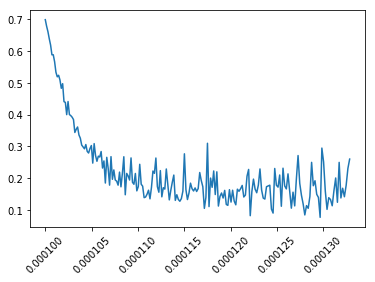

In [54]:
model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()
lrs, losses  = lr_finder(model, 1, train_dl, min_lr=1e-4, max_lr=1e-1, early_stopping=200)

# Training definitions

In [62]:
def compute_AUCs(y, pred):
    AUROCs = []
    for i in range(N_CLASSES):
        auc_i = roc_auc_score(y[:, i].astype(int), pred[:, i])
        AUROCs.append(auc_i)
    return  np.mean(AUROCs)

def ave_auc(probs, ys):
    aucs = [roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(aucs), aucs   


def validate(model, valid_dl):
    
    model.eval()
    total = 0
    sum_loss = 0
    ys = []
    preds = []
    
    for x, y in valid_dl:
        
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        
        batch = y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch
        
        preds.append( out.detach().cpu().numpy())
        ys.append( y.long().cpu().numpy())

 
        
    preds = np.vstack(preds)
    ys = np.vstack(ys)
    mean_auc, aucs = ave_auc(preds, ys)
    
#     print('\n'.join([f'{m:.3f}' for m in auc])+'\n')
    
    return sum_loss / total, mean_auc, aucs

def train(n_epochs, train_dl, valid_dl, model, div_factor=25., max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for i, (x, y) in enumerate(tqdm_notebook(train_dl, leave=False)):

            if unfreeze_during_loop:
                if i == first_unfreeze: model.unfreeze(1)
                if i == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch


        val_loss, measure, _ = validate(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training

In [68]:
epochs = 8

In [67]:
# tiny version

N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation(arc_width=20), filp(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.2881 -  val loss 0.1628 AUC 0.6458


A Jupyter Widget

Ep. 2 - train loss 0.1509 -  val loss 0.1610 AUC 0.6857


A Jupyter Widget

Ep. 3 - train loss 0.1426 -  val loss 0.1681 AUC 0.6922


A Jupyter Widget

Ep. 4 - train loss 0.1292 -  val loss 0.1663 AUC 0.7042


A Jupyter Widget

Ep. 5 - train loss 0.1141 -  val loss 0.1712 AUC 0.6959


A Jupyter Widget

Ep. 6 - train loss 0.0938 -  val loss 0.1743 AUC 0.7089


A Jupyter Widget

Ep. 7 - train loss 0.0746 -  val loss 0.1814 AUC 0.7055


A Jupyter Widget

Ep. 8 - train loss 0.0628 -  val loss 0.1810 AUC 0.7026


In [70]:
# tiny version

class random_rotation_v2:
    """ Rotates an image by deg degrees

    Args: -
    """

    def __init__(self): pass

    def __call__(self, im, deg,
                 mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
        r, c, *_ = im.shape
        M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
        return cv2.warpAffine(im, M, (c, r), borderMode=mode,
                              flags=cv2.WARP_FILL_OUTLIERS + interpolation)

    def options(self, x_shape):
        """Specify the random arguments to be generated every epoch.
        Images must be have same dimensions !
        """
        return {"deg": -1}

    def set_random_choices(self, N, x_shape):
        return {k: np.random.choice([-90,0,90], size=N, replace=True)  for k, v in self.options(x_shape).items()}


N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation_v2(), random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.3406 -  val loss 0.1666 AUC 0.6493


A Jupyter Widget

Ep. 2 - train loss 0.1556 -  val loss 0.1735 AUC 0.6702


A Jupyter Widget

Ep. 3 - train loss 0.1525 -  val loss 0.1693 AUC 0.6736


A Jupyter Widget

Ep. 4 - train loss 0.1434 -  val loss 0.1644 AUC 0.6954


A Jupyter Widget

Ep. 5 - train loss 0.1352 -  val loss 0.1689 AUC 0.7035


A Jupyter Widget

Ep. 6 - train loss 0.1261 -  val loss 0.1664 AUC 0.6972


A Jupyter Widget

Ep. 7 - train loss 0.1152 -  val loss 0.1659 AUC 0.7107


A Jupyter Widget

Ep. 8 - train loss 0.1098 -  val loss 0.1655 AUC 0.7091


In [ ]:
# Whole dataset

transforms=[random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1539 -  val loss 0.1467 AUC 0.7846


A Jupyter Widget

Ep. 2 - train loss 0.1402 -  val loss 0.1474 AUC 0.7900


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1452 AUC 0.7984


A Jupyter Widget

Ep. 4 - train loss 0.1339 -  val loss 0.1426 AUC 0.8193


A Jupyter Widget

In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

In [ ]:
train_df = train_df.sample(frac=1)

for N in [50, 100, 5_000, 10_000, 20_000, 35_000, 50_000, 60_000, 77_880]:
    
    sampled_train_df = train_df[:N]
    
    train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                           transforms=True, shuffle=True, data=data,
                           batch_size=batch_size, half=False, normalize=pretrained)
    
    model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
    save_path = SAVE_DIRECTORY/f"{pretrained}-{N}.pth"
    # save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
    train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

In [20]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = False, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
validate(model, test_dl)

(0.20191780040408833,
 0.8164163548894331,
 [0.7777638937179043,
  0.8882716944725164,
  0.8331421478637311,
  0.6839344107757633,
  0.8366145269199207,
  0.7661666072832656,
  0.7252368098300768,
  0.8640024568362074,
  0.752993899915239,
  0.8507316063175169,
  0.9233914222053733,
  0.8275160380939851,
  0.7879706132917902,
  0.9120928409287741])

In [22]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
TTA_test_metrics_chest(model, test_dl)

val loss 0.2021 and auc 0.8210


(0.20208021653882324, 0.8209861720227334)

In [18]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1535 -  val loss 0.1460 AUC 0.7735


A Jupyter Widget

Ep. 2 - train loss 0.1403 -  val loss 0.1490 AUC 0.7919


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1473 AUC 0.8027


A Jupyter Widget

Ep. 4 - train loss 0.1337 -  val loss 0.1427 AUC 0.8155


A Jupyter Widget

Ep. 5 - train loss 0.1295 -  val loss 0.1388 AUC 0.8338


A Jupyter Widget

Ep. 6 - train loss 0.1251 -  val loss 0.1369 AUC 0.8358


A Jupyter Widget

Ep. 7 - train loss 0.1200 -  val loss 0.1369 AUC 0.8411


A Jupyter Widget

IndexError: index 38728 is out of bounds for axis 0 with size 38728

In [215]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800-{random_state}.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, bar=tqdm_notebook,
      unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

Ep. 1 - train loss 0.1529 -  val loss 0.1456 AUC 0.7908
Ep. 2 - train loss 0.1445 -  val loss 0.1478 AUC 0.7804
Ep. 3 - train loss 0.1399 -  val loss 0.1457 AUC 0.7900
Ep. 4 - train loss 0.1356 -  val loss 0.1409 AUC 0.8095
Ep. 5 - train loss 0.1315 -  val loss 0.1398 AUC 0.8125
Ep. 6 - train loss 0.1269 -  val loss 0.1382 AUC 0.8219
Ep. 7 - train loss 0.1218 -  val loss 0.1373 AUC 0.8233
Ep. 8 - train loss 0.1178 -  val loss 0.1374 AUC 0.8250
